In [11]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import os
from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import Binarize

dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-5 )
tfd = tfp.distributions

def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

def mixd(output):
    rate = tf.math.exp(output[0,:,:,0]) #A 
    s = tf.math.sigmoid(output[0,:,:,1])
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
     tfd.Poisson(rate=rate) #F 
     ]
    mixture = tfd.Mixture(
          cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
          components=components)
    
    return mixture
    
def testnetBernoulli(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64


    output = Conv2D(1, (1, 1), activation=tf.exp)(up01)  # 1 x 64x64
    #output = tfkl.Flatten()(output)
    output = tfpl.IndependentBernoulli((1), tfd.Bernoulli.logits)(output)
    #outpus = tfd.Independent(tfd.Poisson(),name="image")(output)
    model = Model(inputs=inputs, outputs=output)
    return model

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

In [9]:
train, test = provideData(flatten=False,dimension=dimension,batch_size=1,transform=[Binarize()],preTransformation=None)


Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [13]:
t = Trainer(testnetBernoulli,
                    NLL,
                    (train,test),
                    batch_size = 1,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))
t.fit(2000)

[Loaded file]  ./model_data/testnetBernoulli_function/testnetBernoulli_function64x64x5.h5
100
[Loaded file]  ./model_data/testnetBernoulli_function/testnetBernoulli_function64x64x5history.json
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 10)   460         input_5[0][0]                    
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 64, 64, 10)   0           conv2d_20[0][0]                  
_________________________________________________________________________________________________

Epoch 116/2100
10/10 [==============================] - 0s 12ms/step - loss: 49.9715 - mse: 0.0510 - mae: 0.1936 - val_loss: 45.6781 - val_mse: 0.1511 - val_mae: 0.1986
Epoch 117/2100
10/10 [==============================] - 0s 13ms/step - loss: 49.6899 - mse: 0.0484 - mae: 0.1856 - val_loss: 45.6148 - val_mse: 0.1513 - val_mae: 0.1963
Epoch 118/2100
10/10 [==============================] - 0s 13ms/step - loss: 49.4214 - mse: 0.0461 - mae: 0.1778 - val_loss: 45.5190 - val_mse: 0.1513 - val_mae: 0.1938
Epoch 119/2100
10/10 [==============================] - 0s 13ms/step - loss: 49.1704 - mse: 0.0440 - mae: 0.1705 - val_loss: 45.4592 - val_mse: 0.1517 - val_mae: 0.1919
Epoch 120/2100
10/10 [==============================] - 0s 13ms/step - loss: 48.9449 - mse: 0.0425 - mae: 0.1644 - val_loss: 45.4076 - val_mse: 0.1517 - val_mae: 0.1900
Epoch 121/2100
10/10 [==============================] - 0s 14ms/step - loss: 48.7465 - mse: 0.0406 - mae: 0.1582 - val_loss: 45.3344 - val_mse: 0.1524 - va

10/10 [==============================] - 0s 12ms/step - loss: 44.7080 - mse: 0.0263 - mae: 0.0374 - val_loss: 44.4228 - val_mse: 0.1577 - val_mae: 0.1601
Epoch 213/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.6976 - mse: 0.0265 - mae: 0.0372 - val_loss: 44.4212 - val_mse: 0.1586 - val_mae: 0.1609
Epoch 214/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.6990 - mse: 0.0260 - mae: 0.0368 - val_loss: 44.4195 - val_mse: 0.1585 - val_mae: 0.1608
Epoch 215/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.6885 - mse: 0.0261 - mae: 0.0365 - val_loss: 44.4197 - val_mse: 0.1586 - val_mae: 0.1608
Epoch 216/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.6834 - mse: 0.0263 - mae: 0.0365 - val_loss: 44.4184 - val_mse: 0.1579 - val_mae: 0.1601
Epoch 217/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.6764 - mse: 0.0263 - mae: 0.0364 - val_loss: 44.4174 - val_mse: 0.1587 - val_mae: 0.1608
E

10/10 [==============================] - 0s 10ms/step - loss: 44.4504 - mse: 0.0264 - mae: 0.0293 - val_loss: 44.3771 - val_mse: 0.1582 - val_mae: 0.1588
Epoch 309/2100
10/10 [==============================] - 0s 10ms/step - loss: 44.4495 - mse: 0.0264 - mae: 0.0293 - val_loss: 44.3765 - val_mse: 0.1591 - val_mae: 0.1596
Epoch 310/2100
10/10 [==============================] - 0s 11ms/step - loss: 44.4485 - mse: 0.0264 - mae: 0.0292 - val_loss: 44.3767 - val_mse: 0.1584 - val_mae: 0.1590
Epoch 311/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.4472 - mse: 0.0263 - mae: 0.0291 - val_loss: 44.3764 - val_mse: 0.1587 - val_mae: 0.1593
Epoch 312/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.4458 - mse: 0.0268 - mae: 0.0295 - val_loss: 44.3762 - val_mse: 0.1587 - val_mae: 0.1593
Epoch 313/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.4465 - mse: 0.0261 - mae: 0.0288 - val_loss: 44.3761 - val_mse: 0.1589 - val_mae: 0.1594
E

10/10 [==============================] - 0s 13ms/step - loss: 44.3953 - mse: 0.0260 - mae: 0.0271 - val_loss: 44.3673 - val_mse: 0.1589 - val_mae: 0.1591
Epoch 405/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3947 - mse: 0.0270 - mae: 0.0280 - val_loss: 44.3673 - val_mse: 0.1591 - val_mae: 0.1594
Epoch 406/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3943 - mse: 0.0263 - mae: 0.0274 - val_loss: 44.3672 - val_mse: 0.1584 - val_mae: 0.1586
Epoch 407/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3943 - mse: 0.0266 - mae: 0.0276 - val_loss: 44.3671 - val_mse: 0.1591 - val_mae: 0.1593
Epoch 408/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3940 - mse: 0.0265 - mae: 0.0276 - val_loss: 44.3672 - val_mse: 0.1584 - val_mae: 0.1586
Epoch 409/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3934 - mse: 0.0264 - mae: 0.0274 - val_loss: 44.3669 - val_mse: 0.1592 - val_mae: 0.1594
E

10/10 [==============================] - 0s 14ms/step - loss: 44.3764 - mse: 0.0266 - mae: 0.0271 - val_loss: 44.3641 - val_mse: 0.1591 - val_mae: 0.1592
Epoch 501/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3765 - mse: 0.0264 - mae: 0.0269 - val_loss: 44.3640 - val_mse: 0.1584 - val_mae: 0.1585
Epoch 502/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3763 - mse: 0.0265 - mae: 0.0270 - val_loss: 44.3640 - val_mse: 0.1593 - val_mae: 0.1594
Epoch 503/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3761 - mse: 0.0265 - mae: 0.0270 - val_loss: 44.3640 - val_mse: 0.1586 - val_mae: 0.1587
Epoch 504/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3758 - mse: 0.0267 - mae: 0.0272 - val_loss: 44.3640 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 505/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3760 - mse: 0.0262 - mae: 0.0267 - val_loss: 44.3640 - val_mse: 0.1593 - val_mae: 0.1594
E

10/10 [==============================] - 0s 13ms/step - loss: 44.3689 - mse: 0.0263 - mae: 0.0265 - val_loss: 44.3627 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 597/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3687 - mse: 0.0266 - mae: 0.0269 - val_loss: 44.3627 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 598/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3687 - mse: 0.0262 - mae: 0.0265 - val_loss: 44.3627 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 599/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3686 - mse: 0.0269 - mae: 0.0271 - val_loss: 44.3627 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 600/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3686 - mse: 0.0264 - mae: 0.0266 - val_loss: 44.3627 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 601/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3685 - mse: 0.0262 - mae: 0.0265 - val_loss: 44.3627 - val_mse: 0.1586 - val_mae: 0.1587
E

10/10 [==============================] - 0s 13ms/step - loss: 44.3652 - mse: 0.0261 - mae: 0.0262 - val_loss: 44.3621 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 693/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3652 - mse: 0.0270 - mae: 0.0271 - val_loss: 44.3621 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 694/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3651 - mse: 0.0266 - mae: 0.0268 - val_loss: 44.3621 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 695/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3652 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3621 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 696/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3651 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3621 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 697/2100
10/10 [==============================] - 0s 14ms/step - loss: 44.3651 - mse: 0.0268 - mae: 0.0269 - val_loss: 44.3621 - val_mse: 0.1591 - val_mae: 0.1592
E

10/10 [==============================] - 0s 14ms/step - loss: 44.3634 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3618 - val_mse: 0.1593 - val_mae: 0.1594
Epoch 789/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3634 - mse: 0.0267 - mae: 0.0268 - val_loss: 44.3618 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 790/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3634 - mse: 0.0259 - mae: 0.0260 - val_loss: 44.3618 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 791/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3634 - mse: 0.0272 - mae: 0.0273 - val_loss: 44.3618 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 792/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3634 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3618 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 793/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3634 - mse: 0.0258 - mae: 0.0259 - val_loss: 44.3618 - val_mse: 0.1588 - val_mae: 0.1588
E

10/10 [==============================] - 0s 13ms/step - loss: 44.3625 - mse: 0.0269 - mae: 0.0270 - val_loss: 44.3616 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 885/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3625 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3616 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 886/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3625 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3616 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 887/2100
10/10 [==============================] - 0s 11ms/step - loss: 44.3625 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 888/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3625 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3616 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 889/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3625 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1593 - val_mae: 0.1594
E

10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 981/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 982/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 983/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 984/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 985/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3620 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
E

10/10 [==============================] - 0s 12ms/step - loss: 44.3618 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1077/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3618 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1078/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3618 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1079/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3618 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1080/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3618 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1081/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3618 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3616 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1173/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3616 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1174/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3616 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1175/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3616 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1176/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3616 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1177/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3616 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1269/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1270/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1271/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1272/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1273/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1365/2100
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1366/2100
10/10 [==============================] - 0s 14ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1367/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1368/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1369/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1

10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1461/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0258 - mae: 0.0258 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1462/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0270 - mae: 0.0270 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1463/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1464/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1465/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1

10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1557/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1558/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1559/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1560/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1561/2100
10/10 [==============================] - 0s 14ms/step - loss: 44.3615 - mse: 0.0259 - mae: 0.0259 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1653/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1654/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1655/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0259 - mae: 0.0259 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1656/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1657/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3614 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1749/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3614 - val_mse: 0.1582 - val_mae: 0.1582
Epoch 1750/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3614 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1751/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3614 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1752/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1753/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1

10/10 [==============================] - 0s 12ms/step - loss: 44.3614 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1845/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1846/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1847/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3614 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1848/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1849/2100
10/10 [==============================] - 0s 14ms/step - loss: 44.3614 - mse: 0.0259 - mae: 0.0259 - val_loss: 44.3614 - val_mse: 0.1591 - val_mae: 0.1

10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1941/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1942/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3614 - val_mse: 0.1582 - val_mae: 0.1582
Epoch 1943/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3614 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1944/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3614 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1945/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3614 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1587 - val_mae: 0.1

10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 2037/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 2038/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3614 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 2039/2100
10/10 [==============================] - 0s 12ms/step - loss: 44.3614 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3614 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 2040/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3614 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 2041/2100
10/10 [==============================] - 0s 13ms/step - loss: 44.3614 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3614 - val_mse: 0.1583 - val_mae: 0.1

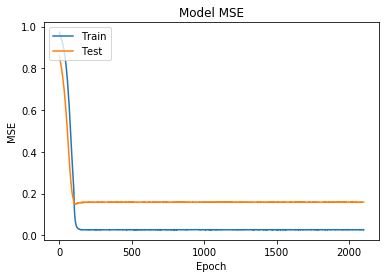

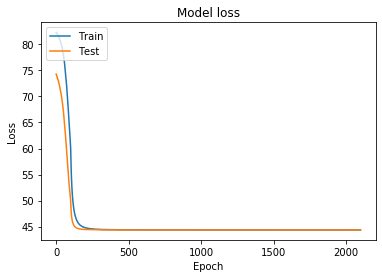

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()